# Vision-Based Sign Language Recognition for Deaf and Dumb Individuals Using LSTM-based Models

###### Required Dependencies

In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

###### Extract Key-points

In [5]:
mp_holistic = mp.solutions.holistic     
mp_drawing = mp.solutions.drawing_utils 

In [6]:
# function to make detection
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [7]:
def draw_styled_landmarks(image, results):
    
    # face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(255, 255, 86), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=1))
    
    # pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 86, 170), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(86, 255, 255), thickness=2, circle_radius=2)) 
    
    # left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0, 127, 255), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))
    
    # right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))

In [8]:
cap = cv2.VideoCapture(0) # read the feed from webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # double-check for webcam access & loop through all frames

        # read feed/frames from webcam
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)
        
        # show image to screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

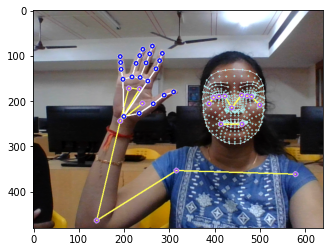

In [9]:
draw_styled_landmarks(frame, results) # apply landmarks
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # color conversion

###### Extract Key-point Values

In [10]:
results.pose_landmarks

landmark {
  x: 0.684630274772644
  y: 0.44840848445892334
  z: -0.8066182136535645
  visibility: 0.9999760389328003
}
landmark {
  x: 0.7192915678024292
  y: 0.3914491534233093
  z: -0.7440083026885986
  visibility: 0.9999499320983887
}
landmark {
  x: 0.7383171916007996
  y: 0.3939177095890045
  z: -0.743659257888794
  visibility: 0.9999276399612427
}
landmark {
  x: 0.7531474828720093
  y: 0.3978990912437439
  z: -0.7437836527824402
  visibility: 0.9999322891235352
}
landmark {
  x: 0.6615572571754456
  y: 0.39404234290122986
  z: -0.725122332572937
  visibility: 0.9999637007713318
}
landmark {
  x: 0.6413567662239075
  y: 0.39750999212265015
  z: -0.7247617244720459
  visibility: 0.9999628663063049
}
landmark {
  x: 0.6231756210327148
  y: 0.40059319138526917
  z: -0.7247928977012634
  visibility: 0.9999764561653137
}
landmark {
  x: 0.7813338041305542
  y: 0.43629565834999084
  z: -0.36260563135147095
  visibility: 0.9999027848243713
}
landmark {
  x: 0.6067312955856323
  y: 0.429

In [11]:
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
    if results.pose_landmarks else np.zeros(33*4)
        
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(468*3)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
    if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

In [12]:
extract_keypoints(results)

array([ 0.68463027,  0.44840848, -0.80661821, ...,  0.30149409,
        0.21346866, -0.01296609])

In [13]:
extract_keypoints(results).shape

(1662,)

In [14]:
data_path = os.path.join('MP_Data') #path for exported data

actions = np.array(['HELLO', 'THANKS', 'I LOVE U','YES','NO','PLEASE','GOOD BYE','SORRY','YOU ARE WELCOME','FAMILY','HOUSE','LOVE']) #actions to be detected

no_sequences = 10 #no. of videos collected for each action

sequence_length = 10 #frame length of each video

In [15]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

###### Collect Key-point Values for Train & Test

In [16]:
cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    #NEW LOOP
    for action in actions: # loop through actions
        for sequence in range(no_sequences): # loop through sequences/videos
            for frame_no in range(sequence_length): # loop through video length 

                # read frames
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)

                # draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW collection wait logic
                if frame_no == 0:
                    cv2.putText(image, 'COLLECTING NOW...', (120, 200), 
                                cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                    cv2.waitKey(1500) # 1.5 seconds break
                else:
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                
                # NEW extract key-points
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_no))
                np.save(npy_path, keypoints)
                
                # break gracefully if hit 'q' on keyboard
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

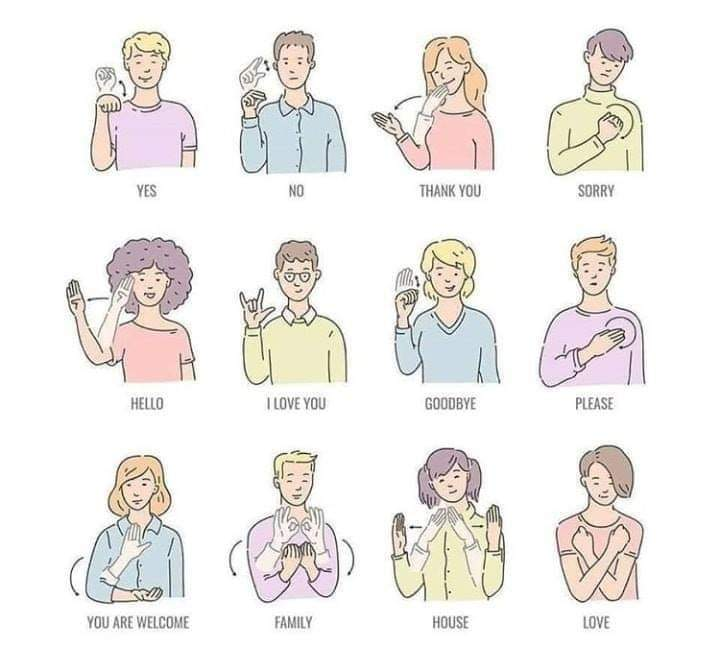

###### Pre-process Data and Create Lables & Features

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [18]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'HELLO': 0,
 'THANKS': 1,
 'I LOVE U': 2,
 'YES': 3,
 'NO': 4,
 'PLEASE': 5,
 'GOOD BYE': 6,
 'SORRY': 7,
 'YOU ARE WELCOME': 8,
 'FAMILY': 9,
 'HOUSE': 10,
 'LOVE': 11}

In [19]:
sequences, labels = [], [] # blank arrays
for action in actions:
    for sequence in range(no_sequences):
        window = [] # blank array
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [20]:
np.array(sequences).shape

(120, 10, 1662)

In [21]:
np.array(labels).shape

(120,)

In [22]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one-hot-encoding

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

###### Build & Train LSTM Neural Network

In [24]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import TensorBoard 

In [25]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [26]:
model = Sequential() 

# add 3 set of LSTM layers
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) 

# add 3 Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # actions layer

In [27]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [28]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
4/4 [==============================] - 3s 35ms/step - loss: 2.4923 - categorical_accuracy: 0.0702
Epoch 2/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.5290 - categorical_accuracy: 0.0439
Epoch 3/1000
4/4 [==============================] - 0s 33ms/step - loss: 2.4977 - categorical_accuracy: 0.0614
Epoch 4/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.4989 - categorical_accuracy: 0.0702
Epoch 5/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.4923 - categorical_accuracy: 0.0351
Epoch 6/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.4850 - categorical_accuracy: 0.0877
Epoch 7/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.4863 - categorical_accuracy: 0.0877
Epoch 8/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.4859 - categorical_accuracy: 0.0789
Epoch 9/1000
4/4 [==============================] - 0s 32ms/step - loss: 2.4813 - categorical_accuracy: 0.0789
E

4/4 [==============================] - 0s 30ms/step - loss: 0.7302 - categorical_accuracy: 0.6579
Epoch 147/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.9407 - categorical_accuracy: 0.6667
Epoch 148/1000
4/4 [==============================] - 0s 37ms/step - loss: 1.4067 - categorical_accuracy: 0.4912
Epoch 149/1000
4/4 [==============================] - 0s 36ms/step - loss: 1.1579 - categorical_accuracy: 0.5702
Epoch 150/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.9166 - categorical_accuracy: 0.5702
Epoch 151/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.8269 - categorical_accuracy: 0.6404
Epoch 152/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.7550 - categorical_accuracy: 0.6842
Epoch 153/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.7274 - categorical_accuracy: 0.6930
Epoch 154/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.6792 - categorical_accuracy: 0.701

4/4 [==============================] - 0s 33ms/step - loss: 0.4595 - categorical_accuracy: 0.8596
Epoch 291/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.5092 - categorical_accuracy: 0.7632
Epoch 292/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.4437 - categorical_accuracy: 0.8070
Epoch 293/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.5595 - categorical_accuracy: 0.7544
Epoch 294/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.5234 - categorical_accuracy: 0.7719
Epoch 295/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.4992 - categorical_accuracy: 0.7719
Epoch 296/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.7181 - categorical_accuracy: 0.6404
Epoch 297/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.6254 - categorical_accuracy: 0.7018
Epoch 298/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.4987 - categorical_accuracy: 0.780

4/4 [==============================] - 0s 31ms/step - loss: 0.4431 - categorical_accuracy: 0.8070
Epoch 435/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.4339 - categorical_accuracy: 0.8421
Epoch 436/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.3835 - categorical_accuracy: 0.8596
Epoch 437/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.4108 - categorical_accuracy: 0.8070
Epoch 438/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.3697 - categorical_accuracy: 0.8421
Epoch 439/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.3475 - categorical_accuracy: 0.8772
Epoch 440/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.3388 - categorical_accuracy: 0.8772
Epoch 441/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.4800 - categorical_accuracy: 0.7895
Epoch 442/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.7003 - categorical_accuracy: 0.719

4/4 [==============================] - 0s 32ms/step - loss: 0.2635 - categorical_accuracy: 0.8772
Epoch 579/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.2233 - categorical_accuracy: 0.9561
Epoch 580/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.2184 - categorical_accuracy: 0.9298
Epoch 581/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.1948 - categorical_accuracy: 0.9298
Epoch 582/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.2498 - categorical_accuracy: 0.9211
Epoch 583/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.2396 - categorical_accuracy: 0.9123
Epoch 584/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.2048 - categorical_accuracy: 0.9298
Epoch 585/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.1930 - categorical_accuracy: 0.9298
Epoch 586/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.1714 - categorical_accuracy: 0.929

4/4 [==============================] - 0s 31ms/step - loss: 0.1272 - categorical_accuracy: 0.9386
Epoch 723/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0853 - categorical_accuracy: 0.9825
Epoch 724/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0934 - categorical_accuracy: 0.9649
Epoch 725/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.1127 - categorical_accuracy: 0.9561
Epoch 726/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.1674 - categorical_accuracy: 0.9211
Epoch 727/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.6399 - categorical_accuracy: 0.7719
Epoch 728/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.3351 - categorical_accuracy: 0.8596
Epoch 729/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.6798 - categorical_accuracy: 0.7982
Epoch 730/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.3142 - categorical_accuracy: 0.877

4/4 [==============================] - 0s 30ms/step - loss: 0.0196 - categorical_accuracy: 0.9912
Epoch 867/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.0246 - categorical_accuracy: 0.9912
Epoch 868/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.0178 - categorical_accuracy: 0.9912
Epoch 869/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0320 - categorical_accuracy: 0.9825
Epoch 870/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0128 - categorical_accuracy: 1.0000
Epoch 871/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.0349 - categorical_accuracy: 0.9912
Epoch 872/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0492 - categorical_accuracy: 0.9737
Epoch 873/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.1240 - categorical_accuracy: 0.9561
Epoch 874/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.1588 - categorical_accuracy: 0.929

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 596972 (2.28 MB)
Trainable params: 596972 

###### Make Predictions

In [30]:
res = model.predict(X_test)#Now, we will make the predictions on the test data based on this model.

1/1 [==============================] - 0s 326ms/step


In [31]:
actions[np.argmax(res[2])]#We can check the prediction for a random action by unpacking the results

'SORRY'

In [32]:
actions[np.argmax(y_test[2])]

'YOU ARE WELCOME'

In [33]:
model.save('fin_mod.h5')

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 21ms/step


In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 2]],

       [[5, 0],
        [0, 1]],

       [[5, 1],
        [0, 0]],

       [[5, 0],
        [1, 0]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]]], dtype=int64)

In [37]:
accuracy_score(ytrue, yhat)

0.8333333333333334

In [38]:
yhat_t = model.predict(X_train)
ytrue_t = np.argmax(y_train, axis=1).tolist()
yhat_t = np.argmax(yhat_t, axis=1).tolist()
multilabel_confusion_matrix(ytrue_t, yhat_t)

4/4 [==============================] - 0s 9ms/step


array([[[106,   0],
        [  0,   8]],

       [[105,   0],
        [  0,   9]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[104,   0],
        [  0,  10]],

       [[105,   0],
        [  0,   9]],

       [[104,   0],
        [  0,  10]],

       [[105,   0],
        [  0,   9]],

       [[105,   0],
        [  0,   9]]], dtype=int64)

In [39]:
accuracy_score(ytrue_t, yhat_t)

1.0

###### Real-time Testing

In [40]:
# render probabilites
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255,0,0), (255,153,0),(255,255,0),(128,0,128),(0,255,255),(128,0,0),(127,255,212),(75,0,130),(250,0,0)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*35), (int(prob*100), 90+num*35), colors[num], -1) # drawing a dynamic rectangle
        cv2.putText(output_frame, actions[num], (0, 85+num*35), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, cv2.LINE_AA)
    return output_frame

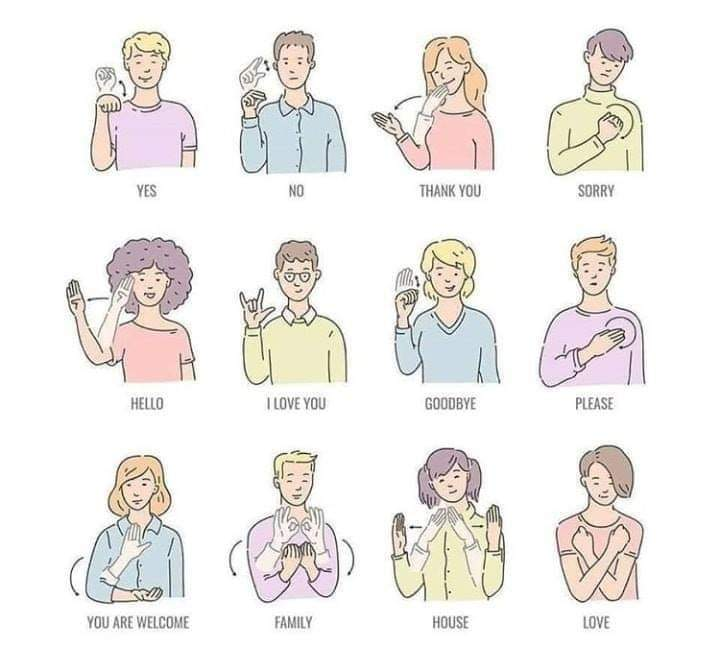

In [41]:
#1. new detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # loop through all frames

        # read frames
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)        
#-------------------------------------------------------------------------
        #2. prediction logic
        keypoints = extract_keypoints(results) # extracting the keypoints
        sequence.append(keypoints)
        sequence = sequence[-10:] #grab last 10 frames
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
#            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))            
#-------------------------------------------------------------------------
        #3. visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                
                if res[np.argmax(res)] > threshold:
                
                    if len(sentence) > 0: #check for words in sentence
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        
            if len(sentence) > 8:
                sentence = sentence[-8:]
#---------------------q----------------------------------------------------                
            #4. visualization probabilites
            image = prob_viz(res, actions, image, colors)
#-------------------------------q------------------------------------------

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2, cv2.LINE_AA)
                               
        # show image on screen
        cv2.imshow('OpenCV Feed',cv2.resize(image,(600,500)))

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

1/1 [==============================] - 0s 18ms/step
